# Basics of Mobile Robotics Project

## Color calibration
In order to detect the colors one should first calibrate 
the filters using the color_calibration.py script. 
Trackbars are used to easily set the HSV parameters 
and isolate the desired color. The parameters are then saved in a txt file.


In [10]:
# !python color_calibration.py

set blue detection, press space when done
set red detection, press space when done


## Main

### Assumptions on the configuration:

- The only elements that can be closer than 20 cm from each other and from the border are the global obstacles.
- Otherwise, every element should have a distance of minimum 20 cm to anything else, including the borders
- During these last 2 weeks, Thymio has learned martial arts so you'd better not even think about kidnapping it.
- If you really want to trick the Thymio, it will probably work.

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import time
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# our modules
import particle_filter
import utils
import Thymio_custom
import global_controller
import Pathplanning
import control
import local_avoidance

### Setting up the Thymio
In order to avoid latency communication problems, we decided to implement precise moving functions directly on the Thymio. We only have to send a target distance/angle and a mode of movement, and the Thymio executes the command alone. Through thorough calibration of the speed and moving time, we achieved a pretty precise navigation.  <br>
We also calibrated the ground sensors, even though the binary map allows imprecisions.<br>
Speaking of it, we generated this map ourselves with a random pattern, to maximise the contrast.


In [2]:
map_file = "data\\mapA0.png"
save_dir = "output\\particles_"

# importing sensor calibration data
config_filename = 'data\\config_TP465.json'
with open(config_filename) as infile:
    config = json.load(infile)
    
# importing the ground map, and converting it to a map in sensor values for each sensor
ground_map = np.flipud(mpimg.imread(map_file).astype(float))[:, :, 0]
vUnitToSensor = np.vectorize(utils.unit_to_sensor, excluded=[1])
ground_map_left = vUnitToSensor(np.transpose(ground_map), config['left'])
ground_map_right = vUnitToSensor(np.transpose(ground_map), config['right'])


### Vision
The vision functions uses OpenCV and can detect the position of the obstacles, goal and thymio,
as well as its orientation. It also detects the map boundaries and projects it.
Draw functions can be used for debugging.<br>

Each feature to detect has a distinct color so we can separate them with a filter.
Several options have been investigated but abandoned because not robust enough. For example: detecting circles
directly with the *circle hough function* or detecting corners with *goodFeaturesToTrack()*. We also tried to compute
the thymio's position and orientation by placing a triangle on top of it indicating where it was looking. But that was
also not precise.<br>
What turned out the be the best choice was computing the contours of a feature and then its center using
respectively *findContours()* and *moments()* <br>
This method is used to determine the map boundaries, a square is placed at each corner, its center matching the corner.
Knowing the corners position one can then project the image.
The goal and the thymio are similarly detected. The latter has two circles on top of it, the biggest determines its
position and the smallest its orientation using basic geometry.<br>
The obstacles are also detected with *findContours()* but are then approximated with *approxPolyDP()* to match a polygon

image capture


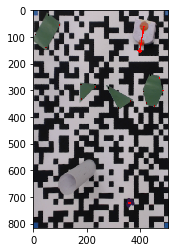

In [3]:
x, y, theta, goal, obsList, vision_img = Pathplanning.take_picture_to_init(margeObs=8.5, cam_capture=0)
plt.imshow(vision_img)

### Obstacle management
Obstacles are managed as polygon, defined by a list of their vertices.

The polygons are expanded to avoid collision between obstacle and robot.
If 2 obstacles are close to each other, their expanded polygon will touch, and they will be merged into one big obstacle.

- Library used for polygon manipulation: Shapely
https://shapely.readthedocs.io/en/stable/manual.html

- Tutorial to merge 2 polygons:
https://deparkes.co.uk/2015/02/28/how-to-merge-polygons-in-python/




### Path finding
We create a Visibility Graph of the map, then perform an A* search on the given graph, and return the shortest path.
In contrary to the Voronoi diagram method, this method is optimal in term of path length.

Librairy used for visiblity Graph generation and Graph search:
https://github.com/MrMinimal64/extremitypathfinder


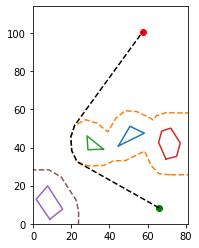

In [4]:
path = Pathplanning.find_path([x, y], goal, obsList, plotFlag=True)

### Global Controller
In order to control the robot on a global level, a pathline is drawn between all waypoints. 
A tube is then drawn around the pathline. 
![Tubular controller](img/tubeP.png)



If the robot is outside the tube, it will try to reach the inside of the tube.
If the robot is inside the tube, it will move toward the next waypoint.

The controller is implemented as a state machine, containing 5 states.


In [5]:
path = [np.array(tup) for tup in path]  # converting tuples in np array
glob_ctrl = global_controller.GlobalController(path, tubeTol=4, outOfTubeAvancementTarget=3, noTurningDistance=3 )

### Communication with the Thymio
We modified the provided interface to best fit our needs. Indeed we needed a high reactivity to be able to avoid 
the local obstacles and a precise incrementation of the odometry. We therefore added some functions of our own in 
the refreshing thread. 

### Local avoidance

In order to detect the obstacles locally, the values of the front sensors are checked regularly. If one of them sees the obstacle, the thymio switches to “local mode” and will immediately stop and then start turning in the direction of the obstacle. (If the center sensor spots the obstacle, then the rotation direction is arbitrary.) Once the thymio is facing the obstacle it will rotate 90° back and move forward, parallel to the obstacle. It will then rotate again to check if it still sees the obstacle, if so the pattern repeats. Once the way is free to go, the thymio moves forwards to pass by the obstacle before switching back to global navigation, with a little specificity to avoid seeing the obstacle again.

<br>
Connection to the thymio:

In [6]:
thymio = Thymio_custom.Thymio.serial(port="COM10", refreshing_rate=0.1, global_controller=glob_ctrl)

### Particle filter
We decided to implement a Monte Carlo localization that we adapted from the paper *Wang S., Colas F., Liu M., Mondada F., Magnenat S. (2018) Localization of Inexpensive Robots with Low-Bandwidth
Sensors.* <br>
A lot of effort was spent to decrease the computation time of this algorithm. Because we weren't satisfied with 
the performance given by the Cython library originally used, we decided to optimize the code with Numba, achieving a 
10 times lower execution time of around 400ms for 150000 particles, wich is great enough for this project. <br>
The three main steps are 
1. Propagating the particles with the measured odometry
2. Calculating the likelihood of each particle with respect to the ground sensor measurements, 
and resampling them according to their probability
3. Estimating the real state using a RANSAC algorithm <br><br>

Initialisation of the localiser:

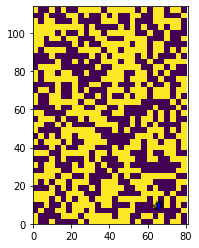

In [7]:
loc = particle_filter.MonteCarlo(ground_map_left, ground_map_right, particles_count=150000, sigma_obs=150., 
                                 prop_uniform=0, alpha_xy=0.1, alpha_theta=0.1,  state_init=[x, y, theta])

# Remove previous output plots, plot the inital state and reset thymio
for fl in glob.glob(save_dir+"*"):
    os.remove(fl)

loc.plot_state( map_back=ground_map, num_particles=50)

Thymio_custom.wait_init(thymio)
Thymio_custom.reset_thymio(thymio)

### main loop

In [ ]:
i = 1
d_reck = np.array([x, y, theta])  # dead_reckoning --> debug but doesn't harm
thymio.start_t = time.time()
try:
    while glob_ctrl.state is not "reachedGoal":

        print("----------------------", i, "t{:0.2f}".format(time.time()-thymio.start_t))
        sensor_left, sensor_right, dx, dy, dth = thymio.read_odometry()

        # localization
        start_t_loc = time.time()
        loc.apply_command(dx, dy, dth)
        loc.apply_obs_and_resample(sensor_left, sensor_right)
        est_pos, confidence = loc.estimate_state()
        duration = time.time() - start_t_loc

        print("Estimated state: {:0.2f} {:0.2f} {:0.2f}".format(est_pos[0], est_pos[1], est_pos[2]))
        if confidence < 0.7:
            print("WARNING LOW CONFIDENCE:", confidence)
        else:
            print("Confidence:", confidence)

        # odometry alone --> debug purposes, but doesn't harm anyone if kept
        d_reck[0:2] += (utils.rot_mat2(d_reck[2]) @ np.asarray([dx, dy]).T).T
        d_reck[2] += dth

        # plotting
        plot_time = time.time()  # yes it takes time !
        loc.plot_state(map_back=ground_map, num_particles=50, odom=d_reck,
                       sens=[sensor_left, sensor_right], path=path, base_filename=save_dir+str(i))
        print("Duration algo, plot : {} , {} ms".format(round(1000*duration), round(1000 * (time.time() - plot_time))))

        glob_ctrl.followPath(est_pos[0:2], est_pos[2], thymio, thymio.nav_flag)

        if thymio.nav_flag == "local":
            thymio.set_var_array("leds.top", [255, 255, 0])  # yellow
            local_avoidance.local_avoidance(thymio)
        elif glob_ctrl.state == "start":  # everything is going well
            thymio.set_var_array("leds.top", [0, 255, 0])  # green
        elif thymio.nav_flag == "global":  # coming back to the planned path
            thymio.set_var_array("leds.top", [0, 0, 255])  # blue

        i += 1
        time.sleep(0.2)  # slow down the loop

    thymio.set_var_array("leds.top", [255, 0, 127])  # pink when loop is exited normally --> goal reached
except:
    thymio.set_var_array("leds.top", [255, 0, 0])  # red
    pass

control.stop_thymio(thymio)

In [ ]:
control.stop_thymio(thymio)